In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import aux_funcs
from pathlib import Path

## Collect data from 3 different containers

30: entropy shuffle (split)

0: blosclz shuffle split

1: zstd shuffle no split

In [2]:
paths = [Path('../data_inputs_temp/'),
         Path('../data_inputs'),
         Path('../data_inputs_wind/')]

files = ['entropy-shuffle', 'blosclz-shuffle-split', 'zstd-shuffle-nosplit']
categories = ["30", "0", "1"]

df_entropy = aux_funcs.get_df_by_category(paths, files[0], categories[0])
df_blosclz = aux_funcs.get_df_by_category(paths, files[1], categories[1])
df_zstd = aux_funcs.get_df_by_category(paths, files[2], categories[2])

# Filter data

Delete data corresponding to special values chunks.

In [3]:
df_shuffle = pd.concat([df_blosclz, df_zstd, df_entropy], axis=1)
df_shuffle = aux_funcs.delete_special_vals(df_shuffle, ["special_vals0", "special_vals1", "special_vals30"])
df_input_x = df_shuffle.iloc[:, [6, 7]]

## Compute best category

In [4]:
df_codecs = df_shuffle.drop(['cratio30', 'speed30', 'special_vals30', 'special_vals0', 'special_vals1'], axis = 1)

In [5]:
dfcratios = pd.concat([df_codecs.iloc[:, 0], df_codecs.iloc[:, 2]], axis=0)
mean_cratio = dfcratios.mean()

cratio0 = df_codecs["cratio0"]
cratio1 = df_codecs["cratio1"]

ncratio0 = cratio0 - mean_cratio
ncratio1 = cratio1 - mean_cratio
all_cratios = np.concatenate((ncratio0, ncratio1), axis=0)

std_cratio = all_cratios.std()
ncratio0 /= std_cratio
ncratio1 /= std_cratio

In [6]:
dfspeeds = pd.concat([df_codecs.iloc[:, 1], df_codecs.iloc[:, 3]], axis =0)
mean_speed = dfspeeds.mean()

speed0 = df_codecs["speed0"]
speed1 = df_codecs["speed1"]

nspeed0 = speed0 - mean_speed
nspeed1 = speed1 - mean_speed
all_speeds = np.concatenate((nspeed0, nspeed1), axis=0)

dsv_speed = all_speeds.std()
nspeed0 /= dsv_speed
nspeed1 /= dsv_speed

### Compute score to determine which category is the best one

In [7]:
theta = 0.5

df_score = pd.DataFrame()
df_score.insert(0, 0, theta*ncratio0 + (1-theta)*nspeed0)
df_score.insert(1, 1, theta*ncratio1 + (1-theta)*nspeed1)

In [8]:
best_categ_shuffle = pd.DataFrame(df_score.idxmax(axis=1), columns=['best_categ'])

In [9]:
categories = best_categ_shuffle['best_categ'].unique()
if len(categories) < (len(files) - 1):
    raise ValueError("Not enough categories in training data")

In [10]:
df_t = pd.DataFrame()
df_t = pd.concat([df_t, df_input_x['cratio30']], axis=1)
df_t = pd.concat([df_t, df_input_x['speed30']], axis=1)
df_t = pd.concat([df_t, best_categ_shuffle], axis=1)

Balance

In [11]:
df_blc = pd.DataFrame()
for i in categories:
    df_i = df_t[df_t['best_categ'] == i]
    df_i = df_i.head(n=14154)
    df_blc = pd.concat([df_blc, df_i], axis = 0)

In [12]:
dfinput_y = pd.concat([df_blc['best_categ']], axis = 1)
dfinput_x = df_blc.drop(['best_categ'], axis = 1)

## Normalize entropy data

In [13]:
dfcratios = pd.concat([dfinput_x.iloc[:, 0]], axis=0)
desv_cratio = dfcratios.std()
mean_cratio = dfcratios.mean()
cratio = dfinput_x["cratio30"]
ncratio = (cratio - mean_cratio) / desv_cratio

In [14]:
dfspeeds = pd.concat([dfinput_x.iloc[:, 1]], axis=0)
mean_speed = dfspeeds.mean()
desv_speed = dfspeeds.std()
speed = dfinput_x["speed30"]
nspeed = (speed - mean_speed) / desv_speed

dfinput_x_norm = pd.DataFrame()
dfinput_x_norm.insert(0, "ncratio", ncratio)
dfinput_x_norm.insert(1, "nspeed", nspeed)

dfinput_x = dfinput_x_norm

# Neural Network with 2 categories

## Split data

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dfinput_x, dfinput_y, test_size=0.1, shuffle=True)

In [16]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

2023-01-03 11:40:20.417094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Build model

In [17]:
from keras import models, layers
import tensorflow

tensorflow.random.set_seed(100)

model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(2,)))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

2023-01-03 11:40:25.550895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

## Train it with data

In [19]:
history = model.fit(x_train, y_train, epochs=50, validation_data = (x_test, y_test))

Epoch 1/50
442/442 [==============================] - 2s 2ms/step - loss: 0.5763 - acc: 0.8198 - val_loss: 0.4653 - val_acc: 0.8994

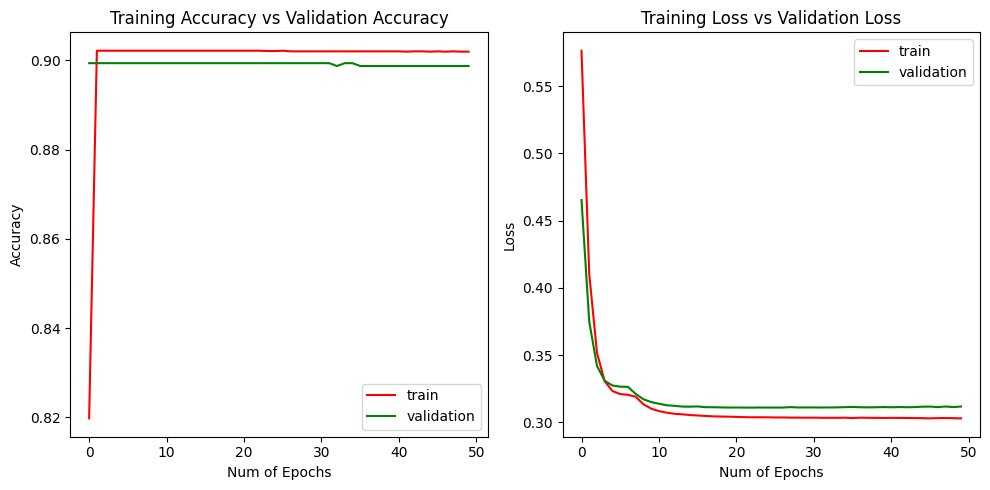

In [20]:
_, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax[0].plot(history.history['acc'], 'r')
ax[0].plot(history.history['val_acc'], 'g')
ax[0].set_xlabel("Num of Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Training Accuracy vs Validation Accuracy")
ax[0].legend(['train', 'validation'])

ax[1].plot(history.history['loss'], 'r')
ax[1].plot(history.history['val_loss'], 'g')
ax[1].set_xlabel("Num of Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("Training Loss vs Validation Loss")
ax[1].legend(['train', 'validation'])

plt.tight_layout()

## Test it

### Rebuil model

Rebuild model until epoch x.

In [21]:
model = models.Sequential()
model.add(layers.Dense(2, activation='relu', input_shape=(2,)))
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train, epochs=6, validation_data = (x_test, y_test))

Epoch 1/6
442/442 [==============================] - 1s 2ms/step - loss: 0.4205 - acc: 0.9022 - val_loss: 0.3713 - val_acc: 0.8994

### Predict train data

In [22]:
y_hat = model.predict(x=x_train)
y_pred_label = np.argmax(y_hat, axis=1)
y_true_label = np.argmax(y_train, axis=1)

442/442 [==============================] - 1s 980us/step


In [23]:
table = pd.crosstab(y_pred_label, y_true_label)
table

col_0,0,1
row_0,,
0,12742,1382


In [24]:
(table[0][0]) / np.sum(table.sum())

0.9021523647691873

### Predict test data

In [25]:
predictions = model.predict(x=x_test)
pred_label = np.argmax(predictions, axis=1)
true_label = np.argmax(y_test, axis=1)

50/50 [==============================] - 0s 2ms/step


In [26]:
table = pd.crosstab(pred_label, true_label)
table

col_0,0,1
row_0,,
0,1412,158


In [27]:
aux = np.abs(pred_label - true_label)
fails = np.count_nonzero(aux)

score = (len(aux) - fails) / len(aux)
score

0.8993630573248408